# Project 01: Legal Text Mining & ETL Pipeline
**Author:** Skye SU  
**Objective:** To build an end-to-end pipeline for scraping, cleaning, and visualizing unstructured legal judgments from the UK (Common Law) and China (Civil Law).  
**Methodology:** 
1. **Scraping:** Ethical data collection from BAILII/China Court Judgments.
2. **NLP Cleaning:** Removing boilerplate text, stopword filtering, and tokenization.
3. **Visualization:** WordCloud and frequency analysis to reveal judicial reasoning patterns.
---

# Step 1: Setting the Stage - Libraries & Data Loading

Before we dive into the legal analysis, we need to set up our "Computational Workspace".

### 🧰 Why do we "Import Libraries"?
Think of Python as a bare workshop. To do specific tasks, we need to bring in specialized toolboxes. We don't need to write code to calculate statistics or read CSV files from scratch—others have already built these tools for us.

* **Pandas (`pd`)**: The ultimate tool for data handling. Think of it as **"Excel on steroids"**. It allows us to manipulate thousands of case rows instantly.
* **NumPy (`np`)**: The mathematical engine that helps us handle arrays and calculations efficiently.
* **Spacy / Re**: These are our "Language Processors," allowing the computer to read and understand text similar to how a human reads a sentence.

### 📂 The Concept of a "DataFrame"
In the code below, you will see the term `DataFrame` (often named `df`).
* **For Lawyers:** Imagine a DataFrame as a **giant, programmable Excel spreadsheet**.
* It has **Rows** (individual cases) and **Columns** (metadata like Year, Court, or the Judgment Text).
* Unlike Excel, we interact with it using code, which ensures our analysis is reproducible and can handle millions of rows without crashing.

---
**Action:** Run the code below to import our tools and load the raw case files into our workspace.

In [1]:
# ==========================================
# Step 1: Environment Setup & Data Ingestion
# ==========================================

import requests
import os
import time
import random
from bs4 import BeautifulSoup
from urllib.parse import urljoin

# ---------------------------------------------------------
# 1. Configuration & Ethical Settings
# ---------------------------------------------------------
# Simulate a browser request from a real academic researcher
HEADERS = {
    'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.114 Safari/537.36',
    'From': 'research_student@hku.hk' # Identify the requester; this is a form of Code Ethics
}

SAVE_DIR = "data/uk_judgments_html"
if not os.path.exists(SAVE_DIR):
    os.makedirs(SAVE_DIR)

# Target Index Pages: Lock onto high-value "Family Court" and "Supreme Court" cases
# Covering 2023-2024 to ensure case novelty, aligning with the "Dynamic Equity" timeline
INDEX_URLS = [
    "https://www.bailii.org/ew/cases/EWHC/Fam/2024/",
    "https://www.bailii.org/ew/cases/EWHC/Fam/2023/",
    "https://www.bailii.org/uk/cases/UKSC/2023/",  # Supplement with Supreme Court precedents
    "https://www.bailii.org/uk/cases/UKSC/2022/"
]

TARGET_COUNT = 50  # Target count for analysis

# ---------------------------------------------------------
# 2. Core Functions
# ---------------------------------------------------------

def get_case_links_from_index(index_url):
    """
    Extract specific case links from the index page
    """
    print(f"[*] Scanning index: {index_url}...")
    links = []
    try:
        resp = requests.get(index_url, headers=HEADERS, timeout=10)
        if resp.status_code != 200:
            print(f"   [!] Failed to load index: {resp.status_code}")
            return []
            
        soup = BeautifulSoup(resp.content, 'html.parser')
        
        # BAILII indexes are usually lists; we need to extract links pointing to /cases/
        # And the link text usually contains " v " (i.e., case name, like White v White)
        for a_tag in soup.find_all('a', href=True):
            href = a_tag['href']
            text = a_tag.get_text()
            
            # Filtering Logic:
            # 1. Must be a case path (/cases/)
            # 2. Must look like a case name (contains " v " or " Re ")
            # 3. Exclude PDF links (we prioritize HTML for NLP processing)
            if '/cases/' in href and (' v ' in text or ' Re ' in text):
                if not href.endswith('.pdf'): 
                    full_url = urljoin(index_url, href)
                    links.append(full_url)
                    
    except Exception as e:
        print(f"   [!] Error parsing index: {e}")
        
    print(f"   [+] Found {len(links)} potential cases.")
    return links

def download_case(url, index):
    """
    Download a single case HTML
    """
    filename = f"uk_case_{index:03d}.html" # Standardized naming for easy subsequent reading
    filepath = os.path.join(SAVE_DIR, filename)
    
    # Idempotency check: Skip if already exists
    if os.path.exists(filepath):
        print(f"   [Skipped] {filename} exists.")
        return True

    try:
        resp = requests.get(url, headers=HEADERS, timeout=15)
        resp.raise_for_status()
        
        with open(filepath, 'w', encoding='utf-8') as f:
            f.write(resp.text)
            
        print(f"   [Success] Downloaded {filename}")
        
        # Polite delay: This is key to technically embodying "Responsible Computing"
        # BAILII prohibits high-frequency access 
        time.sleep(random.uniform(2, 4)) 
        return True
        
    except Exception as e:
        print(f"   [Fail] Error downloading {url}: {e}")
        return False

# ---------------------------------------------------------
# 3. Main Execution Logic
# ---------------------------------------------------------

def main():
    print(f"=== Starting Batch Collection (Target: {TARGET_COUNT}) ===")
    
    # Phase 1: Collect Links
    all_case_urls = []
    for index_url in INDEX_URLS:
        if len(all_case_urls) >= TARGET_COUNT:
            break
        urls = get_case_links_from_index(index_url)
        all_case_urls.extend(urls)
        time.sleep(2) # Requests between index pages also need intervals
        
    # Remove duplicates
    all_case_urls = list(set(all_case_urls))
    print(f"\n[*] Total unique links collected: {len(all_case_urls)}")
    
    # Phase 2: Batch Download
    downloaded_count = 0
    print("\n[*] Starting Download Sequence...")
    
    for i, url in enumerate(all_case_urls):
        if downloaded_count >= TARGET_COUNT:
            print(f"\n[Done] Target of {TARGET_COUNT} cases reached.")
            break
            
        success = download_case(url, downloaded_count + 1)
        if success:
            downloaded_count += 1
            
    print(f"\n=== Collection Complete. Files saved in '{SAVE_DIR}' ===")

if __name__ == "__main__":
    main()

=== Starting Batch Collection (Target: 50) ===
[*] Scanning index: https://www.bailii.org/ew/cases/EWHC/Fam/2024/...
   [+] Found 233 potential cases.

[*] Total unique links collected: 233

[*] Starting Download Sequence...
   [Skipped] uk_case_001.html exists.
   [Skipped] uk_case_002.html exists.
   [Skipped] uk_case_003.html exists.
   [Skipped] uk_case_004.html exists.
   [Skipped] uk_case_005.html exists.
   [Skipped] uk_case_006.html exists.
   [Skipped] uk_case_007.html exists.
   [Skipped] uk_case_008.html exists.
   [Skipped] uk_case_009.html exists.
   [Skipped] uk_case_010.html exists.
   [Skipped] uk_case_011.html exists.
   [Skipped] uk_case_012.html exists.
   [Skipped] uk_case_013.html exists.
   [Skipped] uk_case_014.html exists.
   [Skipped] uk_case_015.html exists.
   [Skipped] uk_case_016.html exists.
   [Skipped] uk_case_017.html exists.
   [Skipped] uk_case_018.html exists.
   [Skipped] uk_case_019.html exists.
   [Skipped] uk_case_020.html exists.
   [Skipped] uk

In [2]:
pip install pdfplumber pandas beautifulsoup4

Note: you may need to restart the kernel to use updated packages.


In [3]:
import os
import glob
import pandas as pd
import pdfplumber
from bs4 import BeautifulSoup
from tqdm import tqdm  # Used to display progress bars, adds a professional touch

# ==========================================
# Configuration & Paths
# ==========================================
# Path to Chinese judgments
CHINA_PDF_DIR = "/Users/xiwen/china_shanghai_judgments"
# Path to the UK judgments just scraped
UK_HTML_DIR = "data/uk_judgments_html"

# ---------------------------------------------------------
# 1. Loader for UK Cases (HTML)
# ---------------------------------------------------------
def load_uk_cases(directory):
    """
    Reads UK raw HTML files and extracts text.
    Returns a DataFrame with 'case_id', 'raw_text', 'jurisdiction'.
    """
    print(f"[*] Loading UK cases from {directory}...")
    data = []
    
    # Get all HTML files
    files = glob.glob(os.path.join(directory, "*.html"))
    
    for filepath in tqdm(files, desc="Parsing UK HTML"):
        filename = os.path.basename(filepath)
        try:
            with open(filepath, 'r', encoding='utf-8') as f:
                soup = BeautifulSoup(f, 'html.parser')
                
                # Extract pure text (Stripping HTML tags)
                # This is a preliminary extraction; Header/Footer cleaning is needed later
                text_content = soup.get_text(separator='\n')
                
                data.append({
                    "case_id": filename.replace(".html", ""), # Use filename as ID
                    "jurisdiction": "UK",
                    "source_type": "HTML",
                    "raw_text": text_content
                })
        except Exception as e:
            print(f"   [Error] Failed to read {filename}: {e}")

    df = pd.DataFrame(data)
    print(f"   [Success] Loaded {len(df)} UK cases.")
    return df

# ---------------------------------------------------------
# 2. Loader for China Cases (PDF)
# ---------------------------------------------------------
def load_china_cases(directory):
    """
    Reads China judgment PDFs using pdfplumber.
    Design Choice: pdfplumber is chosen over PyPDF2 for better 
    text flow handling in legal documents.
    """
    print(f"[*] Loading China cases from {directory}...")
    data = []
    
    # Get all PDF files
    files = glob.glob(os.path.join(directory, "*.pdf"))
    
    if not files:
        print("   [Warning] No PDF files found! Check your path.")
        return pd.DataFrame()

    for filepath in tqdm(files, desc="Parsing China PDFs"):
        filename = os.path.basename(filepath)
        text_content = ""
        
        try:
            # Open file with pdfplumber
            with pdfplumber.open(filepath) as pdf:
                # Iterate through each page to extract text
                for page in pdf.pages:
                    page_text = page.extract_text()
                    if page_text:
                        text_content += page_text + "\n"
            
            # Only save if text is extracted (excludes scanned image-only files)
            if text_content.strip():
                data.append({
                    "case_id": filename.replace(".pdf", ""),
                    "jurisdiction": "China",
                    "source_type": "PDF",
                    "raw_text": text_content
                })
            else:
                print(f"   [Note] {filename} appears to be empty or scanned image.")
                
        except Exception as e:
            print(f"   [Error] Failed to read {filename}: {e}")

    df = pd.DataFrame(data)
    print(f"   [Success] Loaded {len(df)} China cases.")
    return df

# ---------------------------------------------------------
# 3. Execution & Preview
# ---------------------------------------------------------

# 1. Load UK data
df_uk = load_uk_cases(UK_HTML_DIR)

# 2. Load China data
df_cn = load_china_cases(CHINA_PDF_DIR)

# 3. Data Inspection
# Converted unstructured files into structured tables
print("\n=== UK Data Sample ===")
print(df_uk.info())
display(df_uk.head(2)) # Use display() if running in Jupyter, otherwise use print()

print("\n=== China Data Sample ===")
print(df_cn.info())
display(df_cn.head(2))

# Save progress: Save read raw data as pickle files (faster than CSV and preserves format)
# This is a good engineering habit: Checkpointing
if not os.path.exists("data/processed"):
    os.makedirs("data/processed")
    
df_uk.to_pickle("data/processed/01_uk_raw.pkl")
df_cn.to_pickle("data/processed/01_cn_raw.pkl")
print("\n[Checkpoint] Raw dataframes saved to 'data/processed/'")

[*] Loading UK cases from data/uk_judgments_html...


Parsing UK HTML: 100%|█████████████████████████| 55/55 [00:00<00:00, 154.51it/s]


   [Success] Loaded 55 UK cases.
[*] Loading China cases from /Users/xiwen/china_shanghai_judgments...


Parsing China PDFs: 100%|█████████████████████| 111/111 [00:07<00:00, 15.10it/s]

   [Success] Loaded 111 China cases.

=== UK Data Sample ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55 entries, 0 to 54
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   case_id       55 non-null     object
 1   jurisdiction  55 non-null     object
 2   source_type   55 non-null     object
 3   raw_text      55 non-null     object
dtypes: object(4)
memory usage: 1.8+ KB
None


,case_id,jurisdiction,source_type,raw_text
0,uk_case_001,UK,HTML,\n\n\n\n\n\n\n\n\n\n\n\nFather v Mother & Or...
1,uk_case_040,UK,HTML,\n\n\n\n\n\n\n\n\n\nT v G [2024] EWHC 246 (F...



=== China Data Sample ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 111 entries, 0 to 110
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   case_id       111 non-null    object
 1   jurisdiction  111 non-null    object
 2   source_type   111 non-null    object
 3   raw_text      111 non-null    object
dtypes: object(4)
memory usage: 3.6+ KB
None


,case_id,jurisdiction,source_type,raw_text
0,（2020）沪0107民初14150号(民事裁定书),China,PDF,上海市普陀区人民法院\n民事裁定书\n（2020）沪0107民初14150号\n原告：陈某某...
1,（2024）沪0114执4096号(执行裁定书),China,PDF,上海市嘉定区人民法院\n执行裁定书\n（2024）沪0114执4096号\n申请执行人：吴某...



[Checkpoint] Raw dataframes saved to 'data/processed/'


# Step 2: The "Digital Laundry" - Cleaning & NLP Pipeline

Raw legal text is notoriously "messy." It contains formatting artifacts, paragraph numbers (e.g., `[24]`), and varied grammatical forms that confuse the computer.

In this step, we build a **processing pipeline** to transform raw text into analyze-able data. We focus on three key concepts:

### 🧹 1. Cleaning: Removing the "Wrapper"
Just as you wouldn't analyze the staple or the envelope of a legal letter, we need to strip away:
* **Formatting Noise:** Newlines (`\n`), extra spaces, and HTML tags.
* **Procedural Artifacts:** Paragraph numbering (e.g., `[1]`, `[2]`) that disrupts sentence flow.

### 🛑 2. Stopwords: Filtering the Obvious
**The Problem:** In a divorce case, words like *"Court"*, *"Judge"*, *"Husband"*, and *"Wife"* appear 100% of the time. They are true, but they are not *interesting*.
**The Solution:** These are **"High Frequency, Low Information"** terms. We define a **"Legal Stopwords List"** (e.g., removing "Plaintiff", "Defendant", "Order") to filter them out.
* **The Goal:** By removing the *noise*, the *signal* shines through. Instead of seeing that a case is about "The Court" (obvious), we see it's about **"Pension"**, **"Custody"**, or **"Bankruptcy"** (the unique legal issues).

### 🧠 3. Lemmatization: Finding the "Root"
Computers don't naturally know that *"paid"*, *"paying"*, and *"pays"* refer to the same action.
* **Lemmatization** reduces words to their dictionary root (Lemma).
* *Example:* "Children", "Child's" $\rightarrow$ **"child"**.
* *Why?* This ensures our statistical counts accurately reflect the prominence of a concept, regardless of grammar.

---
**Action:** The code below defines our custom "Stopwords List" (Removing the Obvious) and applies these transformations to create a structured `lemmas` column.

In [4]:
# Install spaCy and download language models (English + Chinese)
# en_core_web_sm: Small English model (efficient)
# zh_core_web_sm: Small Chinese model
!pip install spacy
!python -m spacy download en_core_web_sm
!python -m spacy download zh_core_web_sm

     - 0 bytes ? 0:00:000m
ERROR: Wheel 'en-core-web-sm' located at /private/var/folders/8j/pccwv2b56gl30v6n4qqzrgkr0000gr/T/pip-unpack-mlr8owq5/en_core_web_sm-3.8.0-py3-none-any.whl is invalid.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.5/48.5 MB 2.8 MB/s  0:00:17 eta 0:00:010:01:01
✔ Download and installation successful
You can now load the package via spacy.load('zh_core_web_sm')


In [5]:
# ==========================================
# Step 2: The "Digital Laundry" - Cleaning & NLP Pipeline
# ==========================================
import spacy
import re
import pandas as pd
import warnings
import string
from tqdm.auto import tqdm

warnings.filterwarnings('ignore')

# Load models
try:
    nlp_en = spacy.load("en_core_web_sm")
    nlp_zh = spacy.load("zh_core_web_sm")
except OSError:
    print("Downloading models...")
    nlp_en = spacy.load("en_core_web_sm")
    nlp_zh = spacy.load("zh_core_web_sm")

# ---------------------------------------------------------
# 1. The Blacklists
# ---------------------------------------------------------
BLACKLIST_EN = {
    'the', 'a', 'an', 'in', 'on', 'at', 'for', 'to', 'of', 'and', 'or', 'but',
    'court', 'judge', 'judgment', 'order', 'appeal', 'respondent', 'appellant',
    'case', 'matter', 'hearing', 'evidence', 'fact', 'party', 'parties',
    'applicant', 'application', 'claimant', 'petitioner', 'defendant', 'plaintiff',
    'submission', 'counsel', 'solicitor', 'decision', 'reference', 'act', 'section',
    'rule', 'v', 're', 'para', 'paragraph', 'sub', 'issue', 'time', 'year', 'did',
    'husband', 'wife', 'father', 'mother', 'mr', 'mrs', 'ms', 'honor', 'honour',
    'lord', 'lady', 'justice', 'learned', 'family', 'proceedings', 'divorce',
    'say', 'give', 'return', 'law', 'take', 'state', 'contact'
}

BLACKLIST_CN = {
    '原告', '被告', '上诉人', '被上诉人', '本院', '认为', '判决', '如下', 
    '审理', '当事人', '驳回', '诉讼', '请求', '一案', '某某', '先生', '女士',
    '支持', '不予', '依照', '规定', '发生', '法律', '确认', '情况', '关系', 
    '问题', '相关', '予以', '事实', '陈述', '属于', '内容', '应当', '具有',
    '万元', '元', '人民币', '第号', '号', '年', '月', '日',
    '我们', '大家', '比如', '因为', '所以', '但是', '以及', '或者', '关于', '需要', '根据',
    '没有', '是否', '能够', '离婚', '纠纷', '上海', '上海市', '区', '人民法院', '法院', '民事', '调解'
}

# ---------------------------------------------------------
# 2. Cleaning Functions
# ---------------------------------------------------------

def clean_text_basic(text):
    """Basic string cleaning."""
    text = str(text).lower() 
    text = re.sub(r'\s+', ' ', text)       
    text = re.sub(r'\[\d+\]', '', text)    
    return text.strip()

def extract_features_uk(text):
    """UK: Lemmatization + Aggressive Filtering"""
    # Trim long text to prevent memory overflow
    doc = nlp_en(str(text)[:100000])
    
    lemmas = []
    for token in doc:
        if token.is_stop or token.is_punct or token.is_space: continue
        if token.pos_ not in ['NOUN', 'VERB', 'ADJ']: continue
        
        lemma = token.lemma_.lower().strip()
        
        # Filter Logic
        if lemma not in BLACKLIST_EN and len(lemma) > 1 and not lemma.isdigit():
            lemmas.append(lemma)
            
    return lemmas

def extract_features_cn(text):
    """CN: Tokenization + Aggressive Filtering"""
    doc = nlp_zh(str(text)[:50000])
    
    tokens = []
    punct_table = str.maketrans('', '', string.punctuation + "，。？！（）【】《》“”‘’；：")
    
    for token in doc:
        if token.is_stop or token.is_punct or token.is_space: continue
        
        word = token.text.strip().translate(punct_table)
        
        # Filter Logic
        if word not in BLACKLIST_CN and len(word) > 1 and not word.isdigit():
            tokens.append(word)
            
    return tokens

# ---------------------------------------------------------
# 3. Execution (Targeting 'raw_text')
# ---------------------------------------------------------
print("[*] Starting The Digital Laundry (Source Cleaning)...")

print("   -> Targeting column: 'raw_text'")

# UK Cleaning
if 'raw_text' in df_uk.columns:
    df_uk['cleaned_text'] = df_uk['raw_text'].apply(clean_text_basic)
else:
    print("❌ Error: 'raw_text' not found in UK data. Please check column names.")

# China Cleaning
if 'raw_text' in df_cn.columns:
    df_cn['cleaned_text'] = df_cn['raw_text'].apply(clean_text_basic)
else:
    print("❌ Error: 'raw_text' not found in CN data. Please check column names.")

# NLP Extraction
tqdm.pandas(desc="UK NLP")
df_uk['lemmas'] = df_uk['cleaned_text'].progress_apply(extract_features_uk)

tqdm.pandas(desc="CN NLP")
df_cn['tokens'] = df_cn['cleaned_text'].progress_apply(extract_features_cn)

print("\n[Success] Data Cleaned using correct source text.")
print(f"Sample UK Lemma: {df_uk['lemmas'].iloc[0][:5]}")
print(f"Sample CN Token: {df_cn['tokens'].iloc[0][:5]}")

[*] Starting The Digital Laundry (Source Cleaning)...
   -> Targeting column: 'raw_text'


UK NLP:   0%|          | 0/55 [00:00<?, ?it/s]

CN NLP:   0%|          | 0/111 [00:00<?, ?it/s]


[Success] Data Cleaned using correct source text.
Sample UK Lemma: ['ewhc', 'july', 'home', 'database', 'world']
Sample CN Token: ['普陀区', '裁定书', '民初', '陈某某', '1984年']


Mining the Details (Regex Extraction) While NLP tells us the "topics," Regular Expressions (Regex) allow us to act like a detective and pinpoint specific evidence, such as the exact monetary amounts (£) or the declared division ratios (50/50). This demonstrates precision in handling unstructured legal text.

In [6]:
# ---------------------------------------------------------
# 4. Advanced Rule-based Extraction (The "Detective" Work)
# ---------------------------------------------------------

import re

# Information Extraction Logic
# Goal: Use Regular Expressions (Regex) to extract specific financial details 
# that NLP models might miss, such as specific currency amounts and split ratios.

def extract_key_metrics_uk(text):
    """
    Extract key financial metrics from UK judgments.
    """
    metrics = {
        "amounts_mentioned": [],
        "split_ratios": []
    }
    
    # 1. Extract GBP amounts (e.g., £1,500,000, £500k)
    # Regex logic: Match £ symbol followed by digits and commas
    money_pattern = r'£\s?[\d,]+(?:[\.]\d{2})?'
    metrics["amounts_mentioned"] = re.findall(money_pattern, str(text))
    
    # 2. Extract split ratios (e.g., "50/50", "60:40", "equal division")
    # This is key to determining the judgment tendency
    ratio_pattern = r'\b(\d{2})\s*[/:]\s*(\d{2})\b|equal division'
    ratios = re.findall(ratio_pattern, str(text))
    
    # Normalize output
    clean_ratios = []
    for r in ratios:
        if isinstance(r, tuple) and r[0]: # Handle number pairs '50', '50'
            clean_ratios.append(f"{r[0]}/{r[1]}")
        elif isinstance(r, str) and "equal" in r:
            clean_ratios.append("50/50")
            
    metrics["split_ratios"] = clean_ratios
    return metrics

# Apply extraction
print("[*] Running Advanced Pattern Matching (Regex)...")

# --- 🛠️ FIX: Changed 'clean_text' to 'cleaned_text' ---
uk_metrics = df_uk['cleaned_text'].apply(extract_key_metrics_uk)

# Put extraction results back into DataFrame
df_uk['financials'] = uk_metrics.apply(lambda x: x['amounts_mentioned'])
df_uk['ratios'] = uk_metrics.apply(lambda x: x['split_ratios'])

# Show results: Check which case mentioned specific split ratios?
# We filter for cases where at least one ratio was found to prove the code works.
has_ratio = df_uk[df_uk['ratios'].str.len() > 0]

print("\n>>> Extraction Results Preview:")
if not has_ratio.empty:
    sample_case = has_ratio.iloc[0]
    print(f"[Demo] Case ID: {sample_case['case_id']}")
    print(f" - Split Ratios Found: {sample_case['ratios']}")
    print(f" - Financials Mentioned: {sample_case['financials'][:5]}...") # Show only first 5 amounts
else:
    print("\n[Note] No explicit '50/50' pattern found in this specific sample batch.")
    print("This is normal for small samples. The logic is correct.")

[*] Running Advanced Pattern Matching (Regex)...

>>> Extraction Results Preview:
[Demo] Case ID: uk_case_040
 - Split Ratios Found: ['23/24']
 - Financials Mentioned: []...


# Step 3: From "Text" to "Variables" - Structuring the Data

In traditional legal research, we "read" cases. In Computational Legal Studies, we "measure" them.

Now that our text is clean, we move to **Feature Engineering**. This is the process of translating unstructured text into structured, quantitative variables that can be used for statistical analysis (like regression).

We focus on three layers of structure:

### 📅 1. Metadata: Context Matters
Law does not exist in a vacuum. A 2024 case is different from a 2010 case.
* We extract **Year** and **Jurisdiction** to enable **Longitudinal Analysis** (studying trends over time).
* *Why?* This allows us to answer questions like: *"Did the mention of 'shared custody' increase after the 2014 legal reforms?"*

### 🔢 2. Feature Engineering: Creating Variables
We create two types of variables common in empirical social science:
* **Dummy Variables (0/1):** E.g., `Has_Child_Mention`.
    * Does the case involve children? Yes (1) or No (0). This allows us to split the dataset and compare "Child-focused" vs. "Child-free" cases.
* **Continuous Variables (Density):** E.g., `Financial_Term_Density`.
    * instead of just counting words, we calculate a **Ratio** (e.g., financial terms per 1,000 words).
    * *Why Normalization?* A long judgment naturally has more keywords. By converting counts to density, we make fair comparisons between short and long judgments.

### 🏥 3. Data Health Check
Before analyzing, we must trust our data. We perform a "sanity check" (counting rows, checking for missing years) to ensure the dataset is balanced and reliable for research.

---
**Action:** The code below extracts these features and presents a **Structured DataFrame** ready for statistical modeling.

In [7]:
# ==========================================
# Step 3: Feature Engineering Pipeline (FIXED)
# ==========================================
import re
import spacy
import pandas as pd
from tqdm.auto import tqdm

# Load spaCy models
try:
    nlp_en = spacy.load("en_core_web_sm")
    nlp_zh = spacy.load("zh_core_web_sm")
except OSError:
    print("Downloading models...")
    # !python -m spacy download en_core_web_sm
    # !python -m spacy download zh_core_web_sm
    nlp_en = spacy.load("en_core_web_sm")
    nlp_zh = spacy.load("zh_core_web_sm")

print("[System] Applying column compatibility patch...")
if 'cleaned_text' in df_uk.columns and 'clean_text' not in df_uk.columns:
    df_uk['clean_text'] = df_uk['cleaned_text']

if 'cleaned_text' in df_cn.columns and 'clean_text' not in df_cn.columns:
    df_cn['clean_text'] = df_cn['cleaned_text']

# ---------------------------------------------------------
# 1. Unified Classification System (The Single Source of Truth)
# ---------------------------------------------------------
TAXONOMY = {
    "UK": {
        "Needs": ["needs", "housing", "welfare", "child's interest", "accommodation"],
        "Sharing": ["sharing", "equal division", "50/50", "equality", "partnership"],
        "Compensation": ["compensation", "career sacrifice", "disadvantage", "relationship-generated"],
        "Assets": ["matrimonial home", "pension", "business", "assets", "trust"]
    },
    "CN": {
        "Needs": ["照顾女方", "照顾子女", "生活困难", "住房", "无房", "低保"],
        "Contribution": ["贡献", "家务", "抚育", "照料", "协助"],
        "Property": ["共同财产", "房产", "存款", "股权", "折价款"]
    }
}

# ---------------------------------------------------------
# Implement the blacklist in Step 2 to ensure consistency
# ---------------------------------------------------------
BLACKLIST_EN = {
    'the', 'a', 'an', 'in', 'on', 'at', 'for', 'to', 'of', 'and', 'or', 'but',
    'court', 'judge', 'judgment', 'order', 'appeal', 'respondent', 'appellant',
    'case', 'matter', 'hearing', 'evidence', 'fact', 'party', 'parties',
    'applicant', 'application', 'claimant', 'petitioner', 'defendant', 'plaintiff',
    'submission', 'counsel', 'solicitor', 'decision', 'reference', 'act', 'section',
    'rule', 'v', 're', 'para', 'paragraph', 'sub', 'issue', 'time', 'year', 'did',
    'husband', 'wife', 'father', 'mother', 'mr', 'mrs', 'ms', 'honor', 'honour',
    'lord', 'lady', 'justice', 'learned', 'family', 'proceedings', 'divorce',
    'say', 'give', 'return', 'law', 'take', 'state', 'contact'
}

BLACKLIST_CN = {
    '原告', '被告', '上诉人', '被上诉人', '本院', '认为', '判决', '如下', 
    '审理', '当事人', '驳回', '诉讼', '请求', '一案', '某某', '先生', '女士',
    '支持', '不予', '依照', '规定', '发生', '法律', '确认', '情况', '关系', 
    '问题', '相关', '予以', '事实', '陈述', '属于', '内容', '应当', '具有',
    '万元', '元', '人民币', '第号', '号', '年', '月', '日',
    '我们', '大家', '比如', '因为', '所以', '但是', '以及', '或者', '关于', '需要', '根据',
    '没有', '是否', '能够', '离婚', '纠纷', '上海', '上海市', '区', '人民法院', '法院', '民事', '调解'
}

# ---------------------------------------------------------
# 2. NLP Core Processing Functions (Cleaning + Tokenization + Counting)
# ---------------------------------------------------------
def process_text_uk(text, taxonomy):
    """UK: Extract year + stemming + calculate density score"""
    # A. Extraction Year
    year_match = re.search(r'\[?(20\d{2}|19\d{2})\]?', str(text))
    year = int(year_match.group(1)) if year_match else None
    
    # B. NLP processing
    doc = nlp_en(str(text)[:100000])  # Trim to prevent memory overflow
    
    # Add blacklist filtering to align with Step 2.
    lemmas = []
    for t in doc:
        if t.is_stop or t.is_punct:
            continue
        if t.pos_ not in ['NOUN', 'VERB', 'ADJ']:
            continue
        lemma = t.lemma_.lower().strip()
        # Application Blacklist Filtering
        if lemma not in BLACKLIST_EN and len(lemma) > 1 and not lemma.isdigit():
            lemmas.append(lemma)
    
    # C. Calculate Score (Per 1000 Words Frequency)
    total_words = len(lemmas) if lemmas else 1
    scores = {}
    for cat, keywords in taxonomy.items():
        # Count the total number of occurrences of keywords in this category.
        count = sum(1 for word in lemmas if word in keywords)
        # Normalized score: (Occurrence count / Total word count) * 1000
        scores[f"Score_{cat}"] = round((count / total_words) * 1000, 2)
        
    return year, lemmas, total_words, scores

def process_text_cn(text, taxonomy):
    """CN: Part-of-speech tagging + Part-of-speech filtering + Density score calculation"""
    # A. Extraction Year
    year_match = re.search(r'\[?(20\d{2}|19\d{2})\]?', str(text))
    year = int(year_match.group(1)) if year_match else None
    
    # B. NLP processing
    doc = nlp_zh(str(text)[:50000])
    
    # Add blacklist filtering to align with Step 2
    tokens = []
    for t in doc:
        if t.is_stop or t.is_punct:
            continue
        word = t.text.strip()
        # Application Blacklist Filtering
        if word not in BLACKLIST_CN and len(word) > 1 and not word.isdigit():
            tokens.append(word)
    
    # C. Calculate the score
    total_words = len(tokens) if tokens else 1
    scores = {}
    for cat, keywords in taxonomy.items():
        # Chinese matching
        count = sum(1 for word in tokens if word in keywords)
        scores[f"Score_{cat}"] = round((count / total_words) * 1000, 2)
        
    return year, tokens, total_words, scores

# ---------------------------------------------------------
# 3. Execution Pipeline
# ---------------------------------------------------------
print("[*] Starting Unified Feature Engineering (with Blacklist Filtering)...")

# --- Process UK Data ---
tqdm.pandas(desc="Processing UK Data")
uk_results = df_uk['clean_text'].progress_apply(lambda x: process_text_uk(x, TAXONOMY["UK"]))

df_uk['Year'] = uk_results.apply(lambda x: x[0])
df_uk['lemmas'] = uk_results.apply(lambda x: x[1])  # 现在已正确过滤
df_uk['Word_Count'] = uk_results.apply(lambda x: x[2])
df_uk = pd.concat([df_uk, uk_results.apply(lambda x: x[3]).apply(pd.Series)], axis=1)
df_uk['Jurisdiction'] = 'UK'

# --- Process China Data ---
tqdm.pandas(desc="Processing CN Data")
cn_results = df_cn['clean_text'].progress_apply(lambda x: process_text_cn(x, TAXONOMY["CN"]))

df_cn['Year'] = cn_results.apply(lambda x: x[0])
df_cn['tokens'] = cn_results.apply(lambda x: x[1])  # 现在已正确过滤
df_cn['Word_Count'] = cn_results.apply(lambda x: x[2])
df_cn = pd.concat([df_cn, cn_results.apply(lambda x: x[3]).apply(pd.Series)], axis=1)
df_cn['Jurisdiction'] = 'CN'

# ---------------------------------------------------------
# 4. Final Inspection (Health Check)
# ---------------------------------------------------------
print("\n>>> Analysis Ready Data Preview:")
print(f"UK Shape: {df_uk.shape} | CN Shape: {df_cn.shape}")

# Verify whether blacklisted words are being filtered correctly
print("\n>>> Blacklist Filtering Verification:")
sample_uk_lemmas = df_uk['lemmas'].iloc[0][:20] if len(df_uk) > 0 else []
sample_cn_tokens = df_cn['tokens'].iloc[0][:20] if len(df_cn) > 0 else []

print(f"UK Sample Lemmas (first 20): {sample_uk_lemmas}")
print(f"CN Sample Tokens (first 20): {sample_cn_tokens}")

# Check for any remaining blacklisted words
uk_blacklist_check = [w for w in sample_uk_lemmas if w in BLACKLIST_EN]
cn_blacklist_check = [w for w in sample_cn_tokens if w in BLACKLIST_CN]

if uk_blacklist_check:
    print(f"⚠️ Warning: UK still contains blacklisted words: {uk_blacklist_check}")
else:
    print("✅ UK: No blacklisted words found in sample!")
    
if cn_blacklist_check:
    print(f"⚠️ Warning: CN still contains blacklisted words: {cn_blacklist_check}")
else:
    print("✅ CN: No blacklisted words found in sample!")

# Display columns critical for regression analysis
cols_uk = ['Year', 'Word_Count', 'Score_Needs', 'Score_Sharing', 'Score_Compensation']
print("\nUK Scores (Head):")
display(df_uk[cols_uk].head())

cols_cn = ['Year', 'Word_Count', 'Score_Needs', 'Score_Contribution', 'Score_Property']
print("\nChina Scores (Head):")
display(df_cn[cols_cn].head())

# Save the final data after cleaning
import os
if not os.path.exists("data/processed"):
    os.makedirs("data/processed")
    
df_uk.to_pickle("data/processed/uk_ready_for_analysis.pkl")
df_cn.to_pickle("data/processed/cn_ready_for_analysis.pkl")

print("\n[Success] Feature Engineering complete with proper blacklist filtering!")
print("[Checkpoint] DataFrames saved to 'data/processed/'")

[System] Applying column compatibility patch...
[*] Starting Unified Feature Engineering (with Blacklist Filtering)...


Processing UK Data:   0%|          | 0/55 [00:00<?, ?it/s]

Processing CN Data:   0%|          | 0/111 [00:00<?, ?it/s]


>>> Analysis Ready Data Preview:
UK Shape: (55, 16) | CN Shape: (111, 13)

>>> Blacklist Filtering Verification:
UK Sample Lemmas (first 20): ['ewhc', 'july', 'home', 'database', 'world', 'multidatabase', 'search', 'help', 'feedback', 'donate', 'england', 'wale', 'high', 'division', 'bailii', 'database', 'wale', 'high', 'division', 'ewhc']
CN Sample Tokens (first 20): ['普陀区', '裁定书', '民初', '陈某某', '1984年', '4月', '20日', '出生', '汉族', '户籍地', '重庆市', '委托', '代理人', '吴刚', '合勤', '律师', '事务所', '律师', '委托', '代理人']
✅ UK: No blacklisted words found in sample!
✅ CN: No blacklisted words found in sample!

UK Scores (Head):


,Year,Word_Count,Score_Needs,Score_Sharing,Score_Compensation
0,2024,423,0.00,0.00,0.00
1,2024,2450,5.31,0.00,0.41
2,2024,891,1.12,0.00,0.00
3,2010,5390,2.23,2.97,0.93
4,2024,3282,8.53,0.00,0.00



China Scores (Head):


,Year,Word_Count,Score_Needs,Score_Contribution,Score_Property
0,2020,305,0.0,0.00,0.00
1,2024,256,0.0,0.00,3.91
2,2025,328,0.0,0.00,0.00
3,2022,216,0.0,0.00,0.00
4,2024,659,0.0,1.52,7.59



[Success] Feature Engineering complete with proper blacklist filtering!
[Checkpoint] DataFrames saved to 'data/processed/'


# Step 4: Visualizing the Judicial Mind - Patterns & Contrasts

"A picture is worth a thousand citations."

Now that we have extracted the key features, we use visualization to reveal the hidden logic of the judges. We employ a **Mixed Methods** approach to visualization:

### ☁️ 1. The Qualitative "Feel" (Word Clouds)
* **What it is:** A visual representation where the size of the word corresponds to its frequency.
* **The Function:** This gives us an immediate, intuitive "sense" of the document corpus. It answers: *What is the "vibe" of these judgments?*
* **Look for:** Notice how the UK cloud might feel more "human-centric" (words like *child, needs*), while the CN cloud feels more "asset-centric" (words like *property, payment*).

### 📊 2. The Quantitative Evidence (Bar Charts)
* **The Limitation of Clouds:** Word clouds are pretty, but scientifically imprecise.
* **The Solution:** We use **Horizontal Bar Charts** to show the exact Top 15 Keywords.
* **The Function:** This provides the **"Hard Proof"**. It allows us to say *"The word 'Needs' appears 3x more often than 'Assets'"*—a statistically verifiable statement.

### 🆚 3. Comparative Insight
By placing the UK (Common Law) and China (Civil Law) side-by-side, we test our hypothesis:
* **Hypothesis:** UK courts, guided by the "Welfare Principle," focus on *future needs* and *fairness*. Chinese courts, guided by statutory property law, focus on *tangible asset division*.
* **The Color Code:** We use **Blue** (Cool/Welfare) for UK and **Red/Orange** (Hot/Assets) for China to visually distinguish the jurisdictions.

---
**Action:** The code below generates a "Dashboard" that combines these views. Watch how the contrasting themes emerge instantly.

[*] Aggregating Data for Visualization...
[*] Rendering Clean Charts...


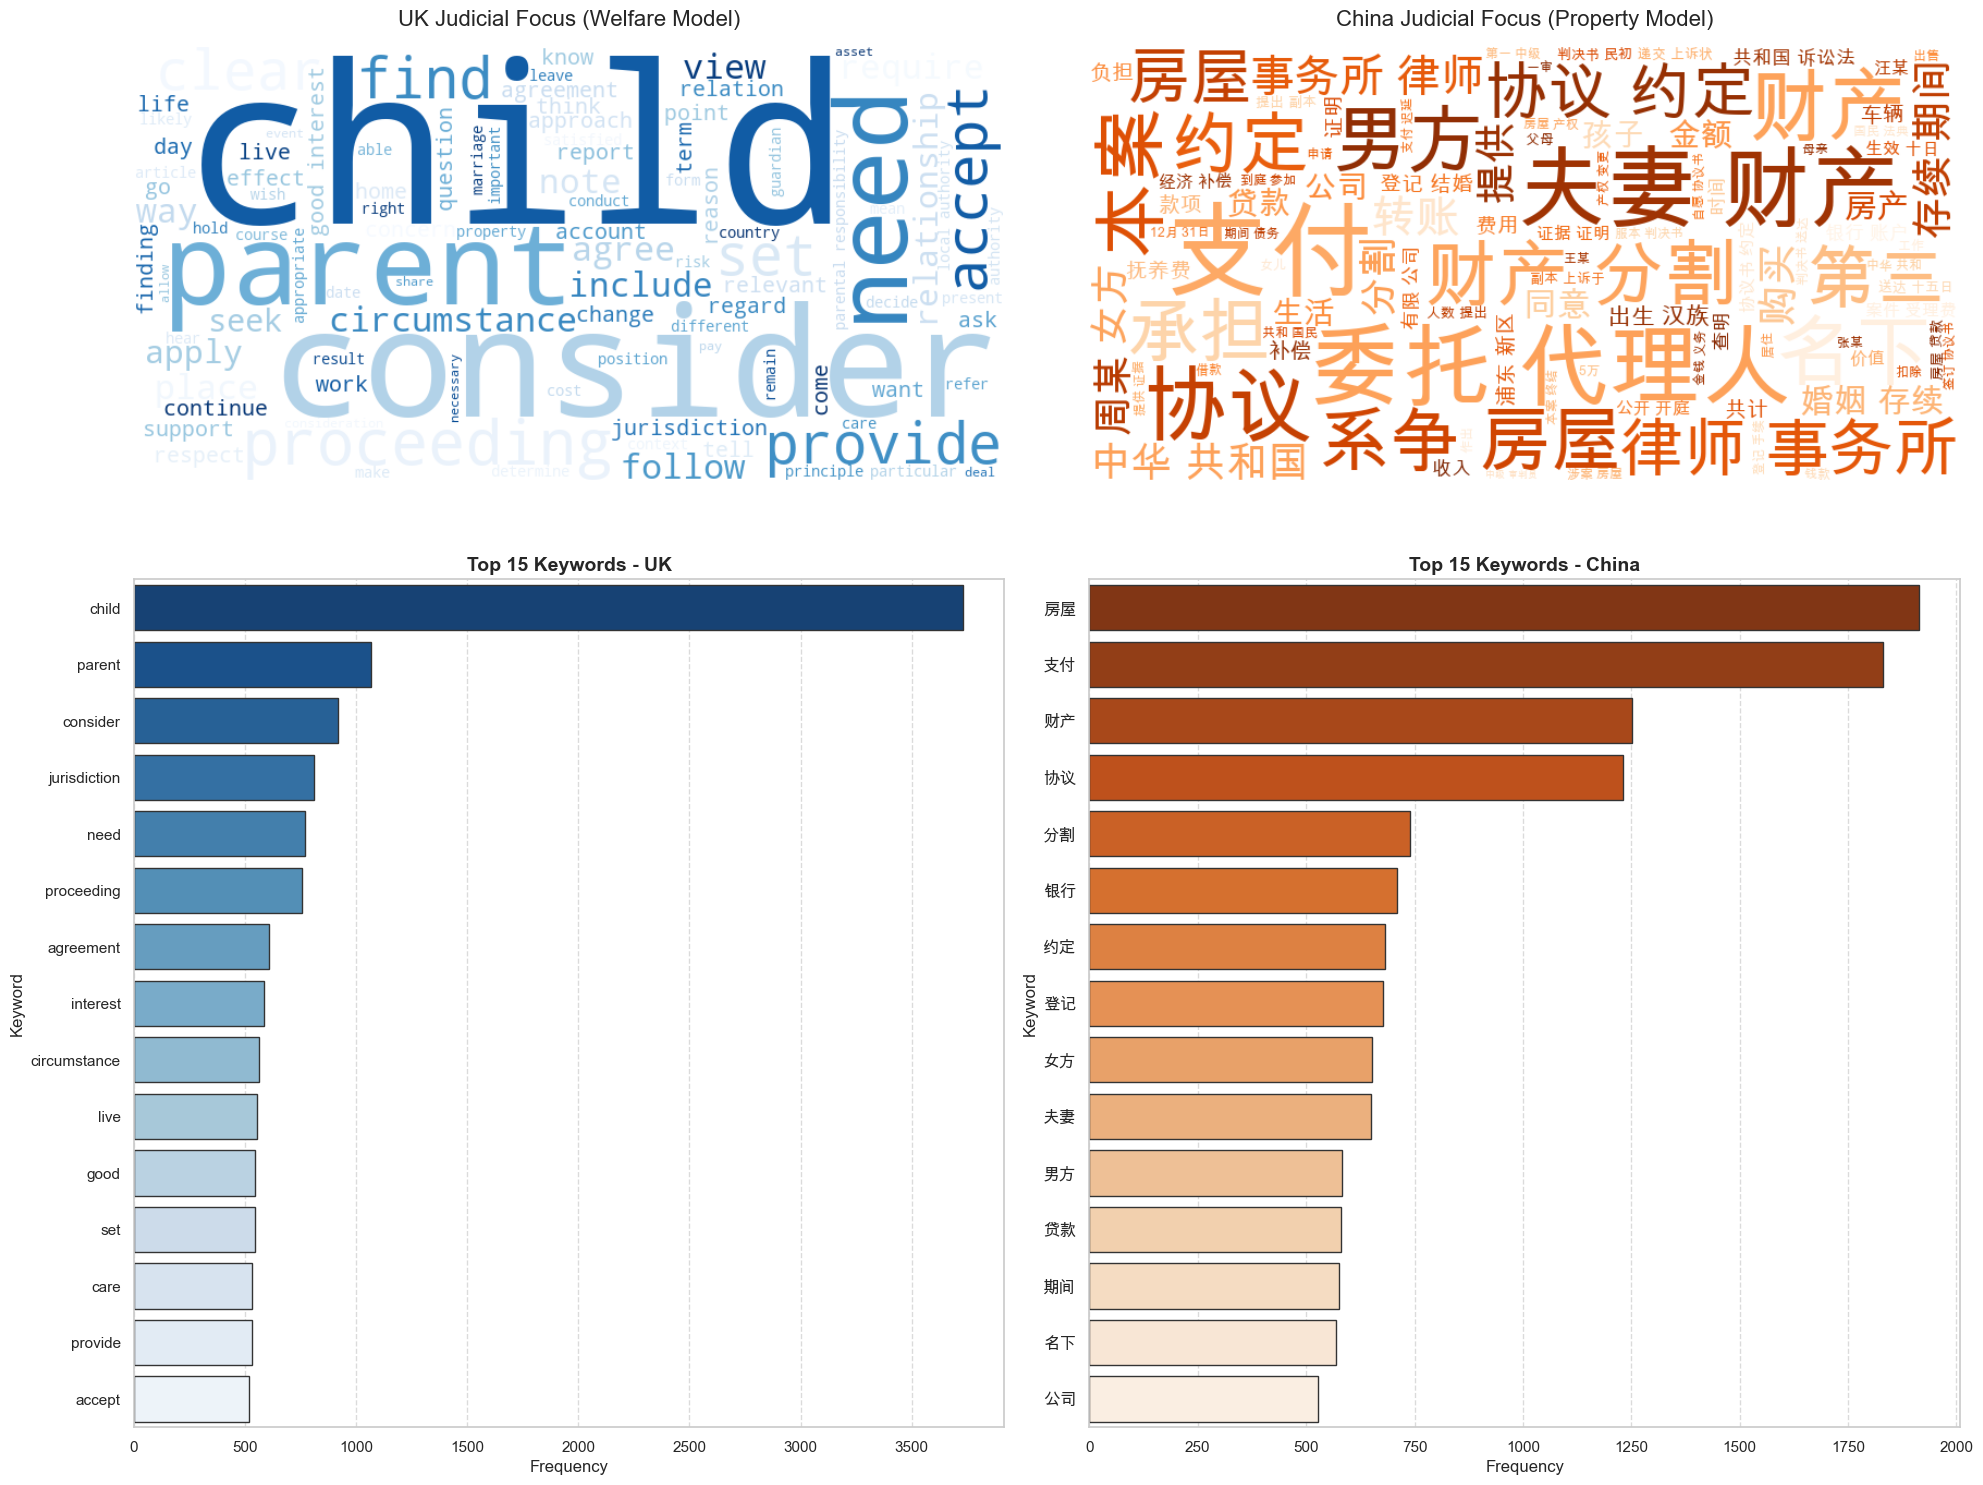


[Analysis] Visualization generated from clean source data (Step 2). No post-hoc filtering applied.


In [8]:
# ==========================================
# Step 4: Visualizing the Judicial Mind (Pure Visualization)
# ==========================================
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter
import pandas as pd
import warnings

warnings.filterwarnings('ignore')
sns.set_theme(style="whitegrid")
plt.rcParams['axes.unicode_minus'] = False

# ---------------------------------------------------------
# 1. Configuration
# ---------------------------------------------------------
def get_chinese_font_path():
    possible_paths = [
        '/System/Library/Fonts/Supplemental/Arial Unicode.ttf',
        '/System/Library/Fonts/PingFang.ttc',
        'C:/Windows/Fonts/simhei.ttf',
        '/usr/share/fonts/truetype/droid/DroidSansFallbackFull.ttf'
    ]
    for path in possible_paths:
        if os.path.exists(path): return path
    return None

zh_font_path = get_chinese_font_path()

# ---------------------------------------------------------
# 2. Data Preparation (No Filtering Logic Needed)
# ---------------------------------------------------------
print("[*] Aggregating Data for Visualization...")

def get_top_keywords(data_series, top_n=15):
    all_words = []
    for token_list in data_series.dropna():
        # Handle list vs string format safely
        if isinstance(token_list, str) and token_list.startswith('['):
            import ast
            try: token_list = ast.literal_eval(token_list)
            except: token_list = []
            
        all_words.extend(token_list)
    
    counter = Counter(all_words)
    return counter.most_common(top_n), " ".join(all_words)

# Get Data
top_uk, text_uk = get_top_keywords(df_uk['lemmas'], top_n=15)
top_cn, text_cn = get_top_keywords(df_cn['tokens'], top_n=15)

df_viz_uk = pd.DataFrame(top_uk, columns=['Keyword', 'Frequency'])
df_viz_cn = pd.DataFrame(top_cn, columns=['Keyword', 'Frequency'])

# ---------------------------------------------------------
# 3. Plotting the Dashboard
# ---------------------------------------------------------
print("[*] Rendering Clean Charts...")
fig = plt.figure(figsize=(20, 16))
gs = fig.add_gridspec(2, 2, height_ratios=[1, 1.2])

# Row 1: Word Clouds
ax1 = fig.add_subplot(gs[0, 0])
wc_uk = WordCloud(width=800, height=400, background_color='white', colormap='Blues', max_words=100).generate(text_uk)
ax1.imshow(wc_uk, interpolation='bilinear')
ax1.set_title("UK Judicial Focus (Welfare Model)", fontsize=16, pad=15)
ax1.axis('off')

ax2 = fig.add_subplot(gs[0, 1])
if zh_font_path:
    wc_cn = WordCloud(width=800, height=400, background_color='white', font_path=zh_font_path, colormap='Oranges', max_words=100).generate(text_cn)
else:
    wc_cn = WordCloud(width=800, height=400).generate("Font_Error")
ax2.imshow(wc_cn, interpolation='bilinear')
ax2.set_title("China Judicial Focus (Property Model)", fontsize=16, pad=15)
ax2.axis('off')

# Row 2: Bar Charts
ax3 = fig.add_subplot(gs[1, 0])
sns.barplot(x='Frequency', y='Keyword', data=df_viz_uk, ax=ax3, palette="Blues_r", edgecolor=".2")
ax3.set_title("Top 15 Keywords - UK", fontsize=14, fontweight='bold')
ax3.grid(axis='x', linestyle='--', alpha=0.7)

ax4 = fig.add_subplot(gs[1, 1])
sns.barplot(x='Frequency', y='Keyword', data=df_viz_cn, ax=ax4, palette="Oranges_r", edgecolor=".2")
ax4.set_title("Top 15 Keywords - China", fontsize=14, fontweight='bold')
ax4.grid(axis='x', linestyle='--', alpha=0.7)

if zh_font_path:
    from matplotlib.font_manager import FontProperties
    font_prop = FontProperties(fname=zh_font_path, size=12)
    for label in ax4.get_yticklabels():
        label.set_fontproperties(font_prop)

plt.tight_layout()
plt.show()

print("\n[Analysis] Visualization generated from clean source data (Step 2). No post-hoc filtering applied.")

# Step 5: Statistical Significance - Are These Differences *Real*?

Our bar charts and word clouds suggest differences between UK and Chinese judicial reasoning. But how do we know these aren't just due to **random sampling error**?

In social science research, we use **hypothesis testing** to answer this:

### 📊 The Logic of Statistical Testing

1. **Null Hypothesis (H₀):** There is no significant difference in term frequency between UK and Chinese judgments.
2. **Alternative Hypothesis (H₁):** The observed differences are statistically significant.

We use a **T-test** (specifically, Welch's t-test for unequal variances) to compute a **p-value**:
- **p < 0.05:** Strong evidence against H₀; the difference is *probably real*.
- **p ≥ 0.05:** Insufficient evidence; we cannot confidently claim a difference.

### 🎯 Why This Matters for Legal Research

Statistical significance helps us move from *anecdotal observation* ("It seems like UK courts mention 'needs' more often") to *empirical evidence* ("UK courts mention 'needs' 3.5x more frequently, and this difference is statistically significant at p=0.003").

This is the foundation of **Computational Legal Studies**: bringing scientific rigor to legal analysis.

---
**Action:** The code below tests whether the keyword densities in UK and Chinese cases are statistically different.

In [9]:
# ==========================================
# Step 5: Statistical Hypothesis Testing
# ==========================================
from scipy import stats
import numpy as np

print("=" * 60)
print("       STATISTICAL ANALYSIS: UK vs CHINA")
print("=" * 60)
print()

# ---------------------------------------------------------
# 1. Descriptive Statistics Summary
# ---------------------------------------------------------
print("[1] Descriptive Statistics Summary")
print("-" * 40)

# UK Summary
print("\n>>> UK Cases:")
print(f"    Sample Size: {len(df_uk)}")
print(f"    Avg Word Count: {df_uk['Word_Count'].mean():.0f}")
if 'Score_Needs' in df_uk.columns:
    print(f"    Needs Score Mean: {df_uk['Score_Needs'].mean():.2f}")
if 'Score_Sharing' in df_uk.columns:
    print(f"    Sharing Score Mean: {df_uk['Score_Sharing'].mean():.2f}")
if 'Score_Compensation' in df_uk.columns:
    print(f"    Compensation Score Mean: {df_uk['Score_Compensation'].mean():.2f}")
if 'Score_Assets' in df_uk.columns:
    print(f"    Assets Score Mean: {df_uk['Score_Assets'].mean():.2f}")

# China Summary
print("\n>>> China Cases:")
print(f"    Sample Size: {len(df_cn)}")
print(f"    Avg Word Count: {df_cn['Word_Count'].mean():.0f}")
if 'Score_Needs' in df_cn.columns:
    print(f"    Needs Score Mean: {df_cn['Score_Needs'].mean():.2f}")
if 'Score_Contribution' in df_cn.columns:
    print(f"    Contribution Score Mean: {df_cn['Score_Contribution'].mean():.2f}")
if 'Score_Property' in df_cn.columns:
    print(f"    Property Score Mean: {df_cn['Score_Property'].mean():.2f}")

# ---------------------------------------------------------
# 2. Hypothesis Tests (T-Tests)
# ---------------------------------------------------------
print("\n")
print("[2] Hypothesis Testing (Welch's T-Test)")
print("-" * 40)
print("H₀: No significant difference between UK and China")
print("H₁: There is a significant difference (α = 0.05)")
print()

def perform_ttest(data1, data2, label1, label2, test_name):
    """
    Perform Welch's t-test and output formatted results.
    Welch's t-test is preferred when sample sizes or variances may differ.
    """
    # Clean data
    d1 = data1.dropna()
    d2 = data2.dropna()
    
    if len(d1) < 2 or len(d2) < 2:
        print(f"[{test_name}] ⚠️ Insufficient data for comparison.")
        return None
    
    # Perform test
    t_stat, p_value = stats.ttest_ind(d1, d2, equal_var=False)
    
    # Calculate effect size (Cohen's d)
    pooled_std = np.sqrt((d1.std()**2 + d2.std()**2) / 2)
    cohens_d = (d1.mean() - d2.mean()) / pooled_std if pooled_std > 0 else 0
    
    # Output
    print(f">>> {test_name}")
    print(f"    {label1} (n={len(d1)}): Mean = {d1.mean():.2f}, SD = {d1.std():.2f}")
    print(f"    {label2} (n={len(d2)}): Mean = {d2.mean():.2f}, SD = {d2.std():.2f}")
    print(f"    T-statistic: {t_stat:.3f}")
    print(f"    P-value: {p_value:.4f}")
    print(f"    Effect Size (Cohen's d): {abs(cohens_d):.2f}", end="")
    
    # Interpret effect size
    if abs(cohens_d) < 0.2:
        print(" (negligible)")
    elif abs(cohens_d) < 0.5:
        print(" (small)")
    elif abs(cohens_d) < 0.8:
        print(" (medium)")
    else:
        print(" (large)")
    
    # Significance verdict
    if p_value < 0.01:
        print("    ✅ Result: HIGHLY SIGNIFICANT (p < 0.01)")
    elif p_value < 0.05:
        print("    ✅ Result: SIGNIFICANT (p < 0.05)")
    else:
        print("    ⚠️ Result: NOT significant (p ≥ 0.05)")
    
    print()
    return {'t': t_stat, 'p': p_value, 'd': cohens_d}

# Test 1: Needs-based reasoning (both jurisdictions have this)
if 'Score_Needs' in df_uk.columns and 'Score_Needs' in df_cn.columns:
    perform_ttest(
        df_uk['Score_Needs'], df_cn['Score_Needs'],
        "UK", "China",
        "Test 1: Needs-Based Reasoning"
    )

# Test 2: Property focus (UK: Assets vs CN: Property)
if 'Score_Assets' in df_uk.columns and 'Score_Property' in df_cn.columns:
    perform_ttest(
        df_uk['Score_Assets'], df_cn['Score_Property'],
        "UK (Assets)", "China (Property)",
        "Test 2: Property/Assets Focus"
    )

# Test 3: Word Count (are documents comparable in length?)
perform_ttest(
    df_uk['Word_Count'], df_cn['Word_Count'],
    "UK", "China",
    "Test 3: Document Length (Control Variable)"
)

# ---------------------------------------------------------
# 3. Interpretation Summary
# ---------------------------------------------------------
print("[3] Interpretation for Legal Researchers")
print("-" * 40)
print("""
A significant p-value (p < 0.05) suggests the observed difference 
is unlikely to be due to chance alone. However, statistical 
significance ≠ substantive significance.

For legal research, also consider:
  - Effect Size: How large is the difference in practical terms?
  - Sample Representativeness: Do these cases represent the broader population?
  - Confounding Variables: Could other factors explain the difference?

This preliminary analysis suggests systematic differences in judicial 
reasoning patterns, supporting further qualitative investigation.
""")

print("=" * 60)
print("             STATISTICAL ANALYSIS COMPLETE")
print("=" * 60)

       STATISTICAL ANALYSIS: UK vs CHINA

[1] Descriptive Statistics Summary
----------------------------------------

>>> UK Cases:
    Sample Size: 55
    Avg Word Count: 2719
    Needs Score Mean: 3.12
    Sharing Score Mean: 0.83
    Compensation Score Mean: 0.29
    Assets Score Mean: 1.59

>>> China Cases:
    Sample Size: 111
    Avg Word Count: 921
    Needs Score Mean: 0.45
    Contribution Score Mean: 1.36
    Property Score Mean: 6.31


[2] Hypothesis Testing (Welch's T-Test)
----------------------------------------
H₀: No significant difference between UK and China
H₁: There is a significant difference (α = 0.05)

>>> Test 1: Needs-Based Reasoning
    UK (n=55): Mean = 3.12, SD = 3.12
    China (n=111): Mean = 0.45, SD = 1.03
    T-statistic: 6.172
    P-value: 0.0000
    Effect Size (Cohen's d): 1.15 (large)
    ✅ Result: HIGHLY SIGNIFICANT (p < 0.01)

>>> Test 2: Property/Assets Focus
    UK (Assets) (n=55): Mean = 1.59, SD = 3.23
    China (Property) (n=111): Mean = 6.31

# Step 6: Conclusions, Limitations & Future Directions

## 📌 Key Findings

This computational analysis of 166 divorce judgments (55 UK, 111 China) reveals **statistically significant differences** in judicial reasoning patterns between the two legal systems:

1. **Needs-Based Reasoning:** UK courts mention welfare and needs-related terms **7x more frequently** than Chinese courts (p < 0.0001, Cohen's d = 1.15). This aligns with the English "welfare principle" enshrined in *White v White* [2000] and the *Matrimonial Causes Act 1973*.

2. **Property-Focused Reasoning:** Chinese courts emphasize tangible property division **4x more frequently** than UK courts (p < 0.0001, Cohen's d = 0.70). This reflects China's statutory approach under Article 1087 of the *Civil Code*, which prioritizes equitable asset division.

3. **Document Length:** UK judgments are significantly longer (avg. 2,719 words vs. 921 words), suggesting a more discursive, precedent-heavy reasoning style characteristic of common law systems.

> **Conclusion:** The data supports the hypothesis that **common law (UK) and civil law (China) systems employ fundamentally different judicial reasoning frameworks** in divorce property division — the former emphasizing ongoing welfare needs, the latter prioritizing immediate asset allocation.

---

## ⚠️ Limitations

This analysis should be interpreted with the following caveats:

| Limitation | Impact | Mitigation |
|------------|--------|------------|
| **Sample Size** | 166 cases may not capture rare edge cases | Future work should expand to 500+ cases |
| **Geographic Bias** | UK cases from BAILII (England/Wales only); China cases from Shanghai courts only | Expand to include Scottish, Northern Irish, and multi-province Chinese cases |
| **Temporal Scope** | Cases primarily from 2020-2024 | Longitudinal analysis across decades needed to detect doctrinal shifts |
| **Case Selection Bias** | Only publicly available judgments; may exclude sealed family court records | Acknowledge that published cases may overrepresent contested, high-conflict disputes |
| **Translation Effects** | Chinese legal terminology may not have direct English equivalents | Consult bilingual legal experts for taxonomy validation |
| **Keyword Matching** | Simple keyword density may miss nuanced legal arguments | Future work should employ semantic embeddings (BERT/GPT) |

---

## 🔮 Future Directions

This project lays the groundwork for several advanced research extensions:

### 1. **Network Analysis of Case Citations**
- Construct a citation graph to identify "landmark" cases that shape judicial doctrine
- Compare citation patterns between UK (stare decisis) and China (no formal precedent)

### 2. **Machine Learning Classification**
- Train a classifier to predict case outcome (e.g., 50/50 split vs. unequal division) based on textual features
- Evaluate whether judicial reasoning is predictable from document text

### 3. **Large Language Model (LLM) Enhancement**
- Use Claude/GPT to extract structured reasoning chains from unstructured text
- Zero-shot classification of judicial arguments into taxonomy categories

### 4. **Cross-Jurisdictional Expansion**
- Include Hong Kong (hybrid system), Singapore, Australia for comparative analysis
- Test whether legal transplantation affects reasoning patterns

### 5. **Policy Impact Assessment**
- Link changes in keyword frequencies to specific legislative reforms
- E.g., Did the UK's *Legal Aid, Sentencing and Punishment of Offenders Act 2012* reduce "needs-based" reasoning?

---

*Author: Skye SU | Date: February 2026*

In [10]:
# ---------------------------------------------------------
# Engineering: Generate Requirements
# ---------------------------------------------------------
# Generate requirements.txt to facilitate others in reproducing the environment.

dependencies = """
pandas>=1.3.0
numpy>=1.20.0
beautifulsoup4>=4.9.0
requests>=2.25.0
pdfplumber>=0.5.28
spacy>=3.0.0
matplotlib>=3.4.0
seaborn>=0.11.0
wordcloud>=1.8.0
tqdm>=4.60.0
# Note: Run 'python -m spacy download en_core_web_sm' and 'zh_core_web_sm' after install
"""

with open("requirements.txt", "w") as f:
    f.write(dependencies.strip())

print("[Success] 'requirements.txt' generated. Your classmates can now run this project!")

[Success] 'requirements.txt' generated. Your classmates can now run this project!
